In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
# constants
EPSILON = 0.1
ALPHA = 0.5
GAMMA = 1
HEIGHT = 4
WIDTH = 12
ACTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]
EPISODES = 500
RUNS = 50

In [83]:
# environment implementation
class CliffWalk:
    def __init__(self, height=HEIGHT, width=WIDTH):
        self.grid = [[-1 for _ in range(width)] for _ in range(height)]
        for i in range(1, width-1): self.grid[height-1][i] = -100
        self.height = height
        self.width = width
        self.start = (height-1, 0)
        self.end = (height-1, width-1)

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        i, j = self.state
        di, dj = ACTIONS[action]
        if i + di >= 0 and i + di < self.height: i += di
        if j + dj >= 0 and j + dj < self.width: j += dj
        reward = self.grid[i][j]
        if reward == -100: self.state = self.start
        else: self.state = (i, j)
        term = self.state == self.end
        return self.state, reward, term

In [75]:
# greedy agent implementation
class GreedyAgent:

    def __init__(self, method, epsilon=EPSILON, alpha=ALPHA, gamma=GAMMA):
        self.q = np.zeros((HEIGHT, WIDTH, len(ACTIONS)))
        self.method = method
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
    
    def act(self, state):
        i, j = state
        if np.random.rand() < self.epsilon: action = np.random.choice(len(ACTIONS))
        else: action = np.random.choice(np.where(self.q[i, j, :] == np.max(self.q[i, j, :]))[0])
        return action
    
    def learn(self, state, action, reward, next_state, next_action=None):
        i, j = state
        next_i, next_j = next_state
        if self.method == 'sarsa':
            self.q[i, j, action] += self.alpha * (reward + self.gamma * self.q[next_i, next_j, next_action] - self.q[i, j, action])
        else:
            self.q[i, j, action] += self.alpha * (reward + self.gamma * np.max(self.q[next_i, next_j, :]) - self.q[i, j, action])



In [84]:
# generate sarsa data
env = CliffWalk()
sarsa_data = np.zeros(EPISODES)
for _ in range(RUNS):
    agent = GreedyAgent('sarsa')
    for i in range(EPISODES):
        rewards = 0.0
        term = False
        state = env.reset()
        action = agent.act(state)
        while not term:
            next_state, reward, term = env.step(action)
            next_action = agent.act(next_state)
            agent.learn(state, action, reward, next_state, next_action)
            state = next_state
            action = next_action
            rewards += reward
        sarsa_data[i] += rewards

sarsa_data /= RUNS

In [85]:
# generate q-learning data
env = CliffWalk()
qlearning_data = np.zeros(EPISODES)
for _ in range(RUNS):
    agent = GreedyAgent('qlearning')
    for i in range(EPISODES):
        rewards = 0.0
        term = False
        state = env.reset()
        while not term:
            action = agent.act(state)
            next_state, reward, term = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            rewards += reward
        qlearning_data[i] += rewards

qlearning_data /= RUNS

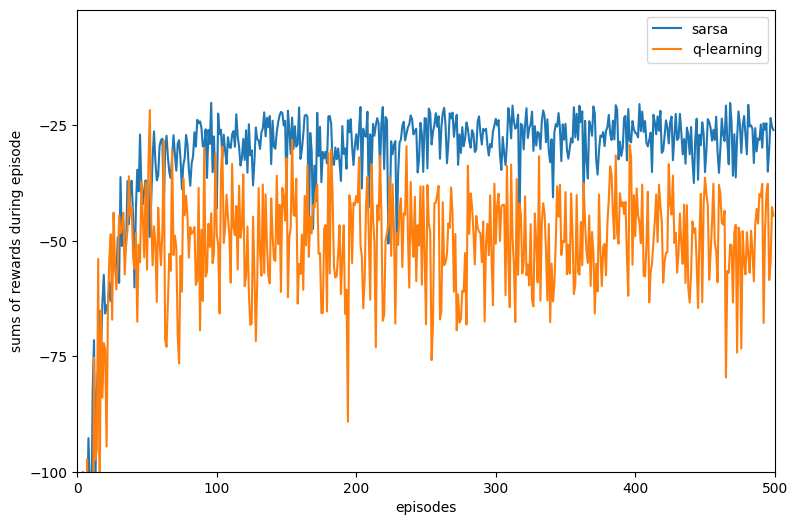

In [86]:
# generate figure

plt.figure(figsize=(9, 6))

plt.plot(sarsa_data, label='sarsa')
plt.plot(qlearning_data, label='q-learning')

plt.xlabel('episodes')
plt.xlim(0, 500)

plt.ylabel('sums of rewards during episode')
plt.ylim(-100, 0)
plt.yticks([-100, -75, -50, -25])

plt.legend()

plt.show()
